In [1]:
# Import and Install Libraries

from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)
import monai
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet, LocalNet, RegUNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset
import torch.nn.functional as F

from glob import glob
import cv2
import torchmetrics

from torch.autograd import Variable

from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import zoom
import pandas as pd

import torch.nn as nn

import numpy as np
import torch
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation
import os
import tempfile
from monai.losses import *
from monai.metrics import *
from piqa import SSIM

import nibabel as nib

import csv

print_config()
set_determinism(40)

MONAI version: 1.0.1
Numpy version: 1.22.3
Pytorch version: 1.13.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /home/mkh/anaconda3/envs/phd/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.12.0
gdown version: 4.6.4
TorchVision version: 0.14.1
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# Directories and some Parameters

dataDir = '3D_Updated'

root_dir = '/home/mkh/MKH/KSA/Dataset/'+dataDir+'/'
print(root_dir)

trainBatch = 1
testBatch = 1

img_size = 256
slice_size = 32

previousWeight = 128

preTrained = 0

EP = 100

num_workers = 0

ExpName = "Vanilla_DLIR_v5aug_ESED"

fileNames = ExpName + '_' + dataDir + '_' +str(img_size) + '_'+str(slice_size) + '_'

# print(fileNames)

/home/mkh/MKH/KSA/Dataset/3D_Updated/


In [3]:
# GPU information
print('How many GPUs = ' + str(torch.cuda.device_count()))

#checking for device

device=torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

How many GPUs = 4
cuda:2
device name NVIDIA GeForce RTX 3090 Ti


In [4]:
# # Make fixed-moving pairs in csv
# # root_dir = '/home/mkh/MKH/KSA/Dataset/'+dataDir+'/'
# splits = ['train', 'val']
# for split in splits:
#     fixed_names = []
#     moving_names = []
#     split_path = os.path.join(root_dir, split)
#     for folders in sorted(os.listdir(split_path)):
#         split_path_folders = os.path.join(split_path, folders)
#         if 'fixed_img' in folders:
#             for fixed_imgs in sorted(os.listdir(split_path_folders)):
#                 split_path_folders_fixed_imgs = os.path.join(split_path_folders, fixed_imgs)
#                 fixed_pt = fixed_imgs.split('_')[0]
#                 for mov_folders in sorted(os.listdir(split_path)):
#                     if 'moving_img' in mov_folders:
#                         mov_split_path_folders = os.path.join(split_path, mov_folders)
#                         for moving_imgs in sorted(os.listdir(mov_split_path_folders)):
#                             moving_pt = moving_imgs.split('_')[0]
#                             if(fixed_pt==moving_pt):
#                                 fixed_names.append(fixed_imgs)
#                                 moving_names.append(moving_imgs)
#     data = {'Fixed':fixed_names, 'Moving':moving_names}
#     dataframe = pd.DataFrame(data=data, index=None)
#     csv_path = root_dir + split + '.csv'
#     dataframe.to_csv(csv_path,index=False)

In [5]:
class EchoDataset3D(Dataset):
    def __init__(self, images_path, flagMask):

        self.images_path = images_path
        self.n_samples = len(images_path)
        self.flagMask = flagMask

    def __getitem__(self, index):
        """ Reading Nifti Files """
        
        # image = cv2.imread(self.images_path[index], cv2.IMREAD_GRAYSCALE)
        img_3d = nib.load(self.images_path[index])
        image = img_3d.get_fdata()

        if self.flagMask==0:
            image = zoom(image, (img_size / image.shape[0], img_size / image.shape[1], slice_size / image.shape[2]))
            # image = cv2.resize(image,(img_size, img_size))
            image = (image-image.min())/(image.max()-image.min())
        else:
            image[image==127]=1
            image[image==255]=2
            image = zoom(image, (img_size / image.shape[0], img_size / image.shape[1], slice_size / image.shape[2]), order=0)
            # image = cv2.resize(image,(img_size, img_size), interpolation=cv2.INTER_NEAREST)
            # image = image/(image.max()) ## (512, 512, 3)
            # print(image.max())
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        self.images_path[index]
        return image

    def __len__(self):
        return self.n_samples

In [6]:
def get_batches(split_dir,
                split,
                fixOrMov,
                flagMask,
                batch_size,
                num_workers,
                pin_memory):
    
    csv_path = pd.read_csv(root_dir + split + "_esed_aug.csv") #Change here
    all_path  = split_dir + csv_path[fixOrMov]
    
    split_data = EchoDataset3D(images_path=all_path, flagMask=flagMask)

    split_loader = DataLoader(split_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory,
                              shuffle=False)

    return split_loader

In [7]:
fixed_train_img = get_batches(split_dir = sorted(glob(root_dir+"train/img/")),
                                        split = 'train',
                                        fixOrMov = 'Fixed',
                                        flagMask = 0,
                                        batch_size = trainBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

fixed_train_msk = get_batches(split_dir = sorted(glob(root_dir+"train/msk/")),
                                        split = 'train',
                                        fixOrMov = 'Fixed',
                                        flagMask = 1,
                                        batch_size = trainBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

moving_train_img = get_batches(split_dir = sorted(glob(root_dir+"train/img/")),
                                        split = 'train',
                                        fixOrMov = 'Moving',
                                        flagMask = 0,
                                        batch_size = trainBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

moving_train_msk = get_batches(split_dir = sorted(glob(root_dir+"train/msk/")),
                                        split = 'train',
                                        fixOrMov = 'Moving',
                                        flagMask = 1,
                                        batch_size = trainBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

print("Train IMG FIXED:", fixed_train_img)
print("Train MSK FIXED:", fixed_train_msk)
print("Train IMG Moving:", moving_train_img)
print("Train MSK Moving:", moving_train_msk)

fixed_val_img = get_batches(split_dir = sorted(glob(root_dir+"val/img/")),
                                        split = 'val',
                                        fixOrMov = 'Fixed',
                                        flagMask = 0,
                                        batch_size = testBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

fixed_val_msk = get_batches(split_dir = sorted(glob(root_dir+"val/msk/")),
                                        split = 'val',
                                        fixOrMov = 'Fixed',
                                        flagMask = 1,
                                        batch_size = testBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)


moving_val_img = get_batches(split_dir = sorted(glob(root_dir+"val/img/")),
                                        split = 'val',
                                        fixOrMov = 'Moving',
                                        flagMask = 0,
                                        batch_size = testBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

moving_val_msk = get_batches(split_dir = sorted(glob(root_dir+"val/msk/")),
                                        split = 'val',
                                        fixOrMov = 'Moving',
                                        flagMask = 1,
                                        batch_size = testBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)


print("Val IMG FIXED:", fixed_val_img)
print("Val MSK FIXED:", fixed_val_msk)
print("Val IMG Moving:", moving_val_img)
print("Val MSK Moving:", moving_val_msk)

Train IMG FIXED: <monai.data.dataloader.DataLoader object at 0x7f7f981f5bb0>
Train MSK FIXED: <monai.data.dataloader.DataLoader object at 0x7f7f981f56d0>
Train IMG Moving: <monai.data.dataloader.DataLoader object at 0x7f7e417bf3a0>
Train MSK Moving: <monai.data.dataloader.DataLoader object at 0x7f7e417bf460>
Val IMG FIXED: <monai.data.dataloader.DataLoader object at 0x7f7e417bf610>
Val MSK FIXED: <monai.data.dataloader.DataLoader object at 0x7f7f981daaf0>
Val IMG Moving: <monai.data.dataloader.DataLoader object at 0x7f7f98316670>
Val MSK Moving: <monai.data.dataloader.DataLoader object at 0x7f7e417c8670>


In [8]:
# Change here
train_csv = pd.read_csv(root_dir + 'train_esed_aug.csv')
val_csv =  pd.read_csv(root_dir + 'val_esed_aug.csv')

print(f'Train Sample numbers (fixed_img) = {len(sorted(glob(root_dir+"train/img/")) + train_csv["Fixed"] )}')
print(f'Train Sample numbers (fixed_msk) = {len(sorted(glob(root_dir+"train/msk/")) + train_csv["Fixed"] )}')
print(f'Train Sample numbers (moving_img) = {len(sorted(glob(root_dir+"train/img/")) + train_csv["Moving"] )}')
print(f'Train Sample numbers (moving_msk) = {len(sorted(glob(root_dir+"/train/msk/")) + train_csv["Fixed"] )}')
print()
print(f'Val Sample numbers (fixed_img) = {len(sorted(glob(root_dir+"val/img/")) + val_csv["Fixed"] )}')
print(f'Val Sample numbers (fixed_msk) = {len(sorted(glob(root_dir+"val/msk/")) + val_csv["Fixed"] )}')
print(f'Val Sample numbers (moving_img) = {len(sorted(glob(root_dir+"val/img/")) + val_csv["Moving"] )}')
print(f'Val Sample numbers (moving_msk) = {len(sorted(glob(root_dir+"val/msk/")) + val_csv["Moving"] )}')
print()

Train Sample numbers (fixed_img) = 200
Train Sample numbers (fixed_msk) = 200
Train Sample numbers (moving_img) = 200
Train Sample numbers (moving_msk) = 200

Val Sample numbers (fixed_img) = 4
Val Sample numbers (fixed_msk) = 4
Val Sample numbers (moving_img) = 4
Val Sample numbers (moving_msk) = 4



In [9]:
dataloaders = {
    'fixed_train_img': fixed_train_img,
    'fixed_train_msk': fixed_train_msk,
    'moving_train_img': moving_train_img,
    'moving_train_msk': moving_train_msk,
    'fixed_val_img': fixed_val_img,
    'fixed_val_msk': fixed_val_msk,
    'moving_val_img': moving_val_img,
    'moving_val_msk': moving_val_msk
    }

In [10]:
fixed_train_img_ = first(dataloaders["fixed_train_img"])[0][0]
fixed_train_msk_ = first(dataloaders["fixed_train_msk"])[0][0]
moving_train_img_ = first(dataloaders["moving_train_img"])[0][0]
moving_train_msk_ = first(dataloaders["moving_train_msk"])[0][0]

fixed_val_img_ = first(dataloaders["fixed_val_img"])[0][0]
fixed_val_msk_ = first(dataloaders["fixed_val_msk"])[0][0]
moving_val_img_ = first(dataloaders["moving_val_img"])[0][0]
moving_val_msk_ = first(dataloaders["moving_val_msk"])[0][0]


print(f"fixed_train_img_ shape: {fixed_train_img_.shape}")
print(f"fixed_train_msk_ shape: {fixed_train_msk_.shape}")
print(f"moving_train_img_ shape: {moving_train_img_.shape}")
print(f"moving_train_msk_ shape: {moving_train_msk_.shape}")

print(f"fixed_val_img_ shape: {fixed_val_img_.shape}")
print(f"fixed_val_msk_ shape: {fixed_val_msk_.shape}")
print(f"moving_val_img_ shape: {moving_val_img_.shape}")
print(f"moving_val_msk_ shape: {moving_val_msk_.shape}")


print(f"fixed_train_img_ Range: {fixed_train_img_.max()} {fixed_train_img_.min()}")
print(f"fixed_train_msk_ range: {fixed_train_msk_.max()} {fixed_train_msk_.min()} {np.unique(fixed_train_msk_)}")
print(f"moving_train_img_ Range: {moving_train_img_.max()} {moving_train_img_.min()}")
print(f"moving_train_msk_ range: {moving_train_msk_.max()} {moving_train_msk_.min()} {np.unique(moving_train_msk_)}")

print(f"fixed_val_img_ Range: {fixed_val_img_.max()} {fixed_val_img_.min()}")
print(f"fixed_val_msk_ range: {fixed_val_msk_.max()} {fixed_val_msk_.min()} {np.unique(fixed_val_msk_)}")
print(f"moving_val_img_ Range: {moving_val_img_.max()} {moving_val_img_.min()}")
print(f"moving_val_msk_ range: {moving_val_msk_.max()} {moving_val_msk_.min()} {np.unique(moving_val_msk_)}")


fixed_train_img_ shape: torch.Size([256, 256, 32])
fixed_train_msk_ shape: torch.Size([256, 256, 32])
moving_train_img_ shape: torch.Size([256, 256, 32])
moving_train_msk_ shape: torch.Size([256, 256, 32])
fixed_val_img_ shape: torch.Size([256, 256, 32])
fixed_val_msk_ shape: torch.Size([256, 256, 32])
moving_val_img_ shape: torch.Size([256, 256, 32])
moving_val_msk_ shape: torch.Size([256, 256, 32])
fixed_train_img_ Range: 1.0 0.0
fixed_train_msk_ range: 2.0 0.0 [0. 1. 2.]
moving_train_img_ Range: 1.0 0.0
moving_train_msk_ range: 2.0 0.0 [0. 1. 2.]
fixed_val_img_ Range: 1.0 0.0
fixed_val_msk_ range: 2.0 0.0 [0. 1. 2.]
moving_val_img_ Range: 1.0 0.0
moving_val_msk_ range: 2.0 0.0 [0. 1. 2.]


In [11]:
# %matplotlib widget

# volumes = [fixed_train_img_, fixed_train_msk_, moving_train_img_, moving_train_msk_, fixed_val_img_, fixed_val_msk_, moving_val_img_, moving_val_msk_]  # Replace with your actual 3D volume data

# # Create a figure and subplots
# fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# # Create initial slices for each volume
# initial_slices = [0] * 8
# current_slices = []

# # Plot the initial slices
# for i, ax in enumerate(axs.flat):
#     ax.axis('off')  # Hide the axis numbers
#     current_slice = ax.imshow(volumes[i][:, :, initial_slices[i]], cmap='gray')
#     current_slices.append(current_slice)

# # Create sliders and axes for each volume
# sliders = []
# slider_axes = []
# for i, ax in enumerate(axs.flat):
#     ax_slider = plt.axes([ax.get_position().x0, ax.get_position().y0 - 0.05, ax.get_position().width, 0.02])
#     slider = Slider(ax=ax_slider, label=f'Slice {i+1}', valmin=0, valmax=volumes[i].shape[2] - 1, valinit=initial_slices[i], valstep=1)
#     sliders.append(slider)
#     slider_axes.append(ax_slider)

# # Update the plots when the slider values change
# def update_slices():
#     for i, slider in enumerate(sliders):
#         current_slices[i].set_data(volumes[i][:, :, int(slider.val)])

#     fig.canvas.draw_idle()

# for slider in sliders:
#     slider.on_changed(lambda event: update_slices())

# # Animation function
# def animate(i):
#     # Increment the slice values for each volume
#     slice_vals = [(initial_slices[j] + i) % volumes[j].shape[2] for j in range(8)]

#     # Update the slider values
#     for j, slider in enumerate(sliders):
#         slider.set_val(slice_vals[j])

#     # Update the plots
#     update_slices()

# # Create the animation
# animation = FuncAnimation(fig, animate, frames=volumes[0].shape[2]*2, interval=200)

# # Set up plot settings
# plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.15)

# # Display the plot
# plt.show()



In [12]:
# %matplotlib widget

# volume = fixed_train_img_  # Replace this with your actual 3D volume data

# # Create a figure and axes for the plot
# fig, ax = plt.subplots()

# # Plot the initial slice
# initial_slice = 0
# current_slice = ax.imshow(volume[:, :, initial_slice], cmap='gray')

# # Create a slider for selecting the slice
# ax_slider = plt.axes([0.2, 0.03, 0.6, 0.05])
# slider = Slider(ax=ax_slider, label='Slice', valmin=0, valmax=volume.shape[2] - 1, valinit=initial_slice, valstep=1)

# # Update the plot when the slider value changes
# def update_slice(val):
#     current_slice.set_data(volume[:, :, int(val)])
#     fig.canvas.draw_idle()

# slider.on_changed(update_slice)

# # Set up plot settings
# plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.15)

# # Display the plot
# plt.show()

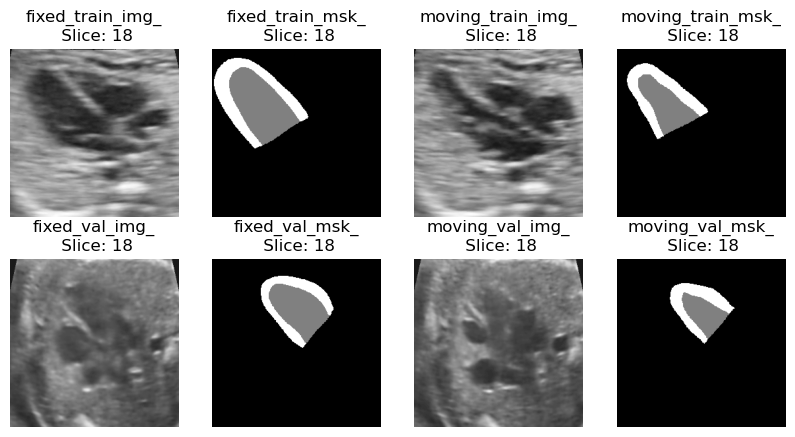

In [13]:
plt.figure("check", (10, 5))
train_slice_no = 18
val_slice_no = 18

plt.subplot(2, 4, 1)
plt.title("fixed_train_img_\n Slice: "+str(train_slice_no))
plt.imshow(fixed_train_img_[:,:,train_slice_no], cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.title("fixed_train_msk_\n Slice: "+str(train_slice_no))
plt.imshow(fixed_train_msk_[:,:,train_slice_no], cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.title("moving_train_img_\n Slice: "+str(train_slice_no))
plt.imshow(moving_train_img_[:,:,train_slice_no], cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 4)
plt.title("moving_train_msk_\n Slice: "+str(train_slice_no))
plt.imshow(moving_train_msk_[:,:,train_slice_no], cmap="gray")
plt.axis('off')


plt.subplot(2, 4, 5)
plt.title("fixed_val_img_\n Slice: "+str(val_slice_no))
plt.imshow(fixed_val_img_[:,:,val_slice_no], cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 6)
plt.title("fixed_val_msk_\n Slice: "+str(val_slice_no))
plt.imshow(fixed_val_msk_[:,:,val_slice_no], cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 7)
plt.title("moving_val_img_\n Slice: "+str(val_slice_no))
plt.imshow(moving_val_img_[:,:,val_slice_no], cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 8)
plt.title("moving_val_msk_\n Slice: "+str(val_slice_no))
plt.imshow(moving_val_msk_[:,:,val_slice_no], cmap="gray")
plt.axis('off')

plt.show()

In [14]:
mod = RegUNet(
    spatial_dims=3,
    in_channels=2,
    num_channel_initial=32,
    depth = 3,
    extract_levels=[3],
    out_activation=None,
    out_channels=3,
    out_kernel_initializer="zeros",
    concat_skip=False)

        

inputs = torch.randn((1, 2, img_size, img_size, slice_size))

y = mod(inputs)
print(y.shape)

import torch, torchinfo
# from torchviz import make_dot, make_dot_from_trace
    
# make_dot(y, params=dict(mod.named_parameters()),
#          show_attrs=False,
#          show_saved=False).render(fileNames, format="png")

torchinfo.summary(mod, input_size=(1, 2, img_size, img_size, slice_size), depth=10)

torch.Size([1, 3, 256, 256, 32])


Layer (type:depth-idx)                             Output Shape              Param #
RegUNet                                            [1, 3, 256, 256, 32]      --
├─ModuleList: 1-5                                  --                        (recursive)
│    └─Sequential: 2-1                             [1, 32, 256, 256, 32]     --
│    │    └─Convolution: 3-1                       [1, 32, 256, 256, 32]     --
│    │    │    └─Conv3d: 4-1                       [1, 32, 256, 256, 32]     1,728
│    │    │    └─ADN: 4-2                          [1, 32, 256, 256, 32]     --
│    │    │    │    └─BatchNorm3d: 5-1             [1, 32, 256, 256, 32]     64
│    │    │    │    └─ReLU: 5-2                    [1, 32, 256, 256, 32]     --
│    │    └─RegistrationResidualConvBlock: 3-2     [1, 32, 256, 256, 32]     --
│    │    │    └─ModuleList: 4-6                   --                        (recursive)
│    │    │    │    └─Convolution: 5-3             [1, 32, 256, 256, 32]     --
│    │    │   

In [15]:
model = mod.to(device)

if preTrained:
    model.load_state_dict(torch.load(os.path.join(root_dir, ExpName + '_' + dataDir + '_' +str(previousWeight) + '_'+'.pth')))


warp_layer = Warp().to(device)

# image_loss = MSELoss()

image_loss = GlobalMutualInformationLoss()

# class SSIMLoss(SSIM):
#     def forward(self, x, y):
#         return 1. - super().forward(x, y)
    

# label_SSIM = SSIMLoss(n_channels=1).to(device) # .cuda() if you need GPU support

label_loss = DiceLoss()

# label_loss = MultiScaleLoss(label_loss, scales=[0, 1, 2, 4, 8, 16])

regularization = BendingEnergyLoss()

optimizer = torch.optim.Adam(model.parameters(), 0.0002)

# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5, verbose=True)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# dice_metric = compute_meandice(y_pred, y, include_background=True)

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


In [16]:
def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.Tensor to a one-hot Tensor.
    
    Parameters
    ----------
    labels : torch.Tensor
        N x 1 x D x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer
        Number of classes in labels.
    
    Returns
    -------
    target : torch.Tensor
        N x C x D x H x W, where C is class number. One-hot encoded.
    '''
    labels = labels.long()
    one_hot = torch.zeros(labels.size(0), C, labels.size(2), labels.size(3), labels.size(4)).to(device)
    labels = labels.squeeze(1)
    target = one_hot.scatter_(1, labels.unsqueeze(1), 1)
        
    return target

In [17]:
max_epochs = EP
epoch_loss_values = []
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_val_loss_values = []
epoch_loss_d_values = []
epoch_loss_g_values = []
metric_values = []
best_loss = 1e10
best_dsc = 0
k=1


for epoch in range(max_epochs):
    print("-" * 100)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0, 0

    epoch_DSC, epoch_L2, epoch_MI, epoch_ddf = 0, 0, 0, 0

    epoch_loss_d, epoch_loss_g=0,0
    
    for fixed_train_img_, fixed_train_msk_, moving_train_img_, moving_train_msk_ in zip(fixed_train_img,
                                                                                    fixed_train_msk, moving_train_img,
                                                                                    moving_train_msk):    
        step += 1
        
        optimizer.zero_grad()
        # optim_d.zero_grad()

        fixed_train_img_ = fixed_train_img_.to(device)
        fixed_train_msk_ = fixed_train_msk_.to(device)
        moving_train_img_ = moving_train_img_.to(device)
        moving_train_msk_ = moving_train_msk_.to(device)
        
        ddf_train = model(torch.cat((moving_train_img_, fixed_train_img_), dim=1))
        
        pred_image_train = warp_layer(moving_train_img_, ddf_train)
        pred_mask_train = warp_layer(moving_train_msk_, ddf_train)

        # real_label = label_real(fixed_train_img_.size(0))
        # fake_label = label_fake(fixed_train_img_.size(0))


        # output_real = discriminator(fixed_train_img_)
        # loss_real = criterion(output_real, real_label)
        # loss_real.backward()

        # output_fake = discriminator(pred_image_train.detach())
        # loss_fake = criterion(output_fake, fake_label)
        # loss_fake.backward()

        # optim_d.step()

        # loss_d = (loss_real + loss_fake)/2

        # epoch_loss_d += loss_d.item()

        # output = discriminator(pred_image_train)
        
        # loss_g = criterion(output, real_label)

        imageLOSS = image_loss(pred_image_train, fixed_train_img_)
        
        labelDSC = label_loss(fixed_train_msk_, pred_mask_train)

        # labelDSC = label_loss(make_one_hot(pred_mask_train, C=3), make_one_hot(fixed_train_msk_, C=3))

        # labelGlobal =  globalLoss(fixed_train_msk_, pred_mask_train)-1
        
        regLOSS  = regularization(ddf_train)

        loss = imageLOSS 
    
        # loss_g.backward(retain_graph=True)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.item()

        # epoch_loss_g += loss_g.item()
        epoch_DSC += labelDSC.item()
        # epoch_L2 += labelGlobal.item()
        epoch_MI += imageLOSS.item()
        epoch_ddf += regLOSS.item()


        
        dice_metric(y_pred = make_one_hot(pred_mask_train, C=3), y=make_one_hot(fixed_train_msk_, C=3))

    # exp_lr_scheduler.step()
    for param_group in optimizer.param_groups:
        print("LR is == ", param_group['lr'])


    metric = dice_metric.aggregate().item()
    dice_metric.reset()
    epoch_loss /= step

    # epoch_loss_g /=step
    # epoch_loss_d /= step

    epoch_DSC /= step
    # epoch_L2 /= step
    epoch_MI /= step
    epoch_ddf /= step

    epoch_loss_values.append(epoch_loss)
    # epoch_loss_d_values.append(epoch_loss_d)
    # epoch_loss_g_values.append(epoch_loss_g)

    print(f"For epoch: {epoch + 1}, Average train loss: {epoch_loss:.5f} !")
    print(f"For epoch: {epoch + 1}, Average train DSC: {metric:.5f} !\n")

    print(f"For epoch: {epoch + 1}, Average train DSC: {epoch_DSC:.5f} !")
    # print(f"For epoch: {epoch + 1}, Average train L2: {epoch_L2:.5f} !")
    print(f"For epoch: {epoch + 1}, Average train MI: {epoch_MI:.5f} !")
    print(f"For epoch: {epoch + 1}, Average train DDF: {epoch_ddf:.5f} !")
    # print(f"For epoch: {epoch + 1}, Average train D Loss: {epoch_loss_d:.5f} !")
    # print(f"For epoch: {epoch + 1}, Average train G Loss: {epoch_loss_g:.5f} !")
    
    print("-" * 60)
    if (epoch + 1) % val_interval == 0 or epoch == 0:
        model.eval()
        val_loss = 0
        val_met = 0
        step = 0
        with torch.no_grad():
            for fixed_val_img_, fixed_val_msk_, moving_val_img_, moving_val_msk_ in zip(fixed_val_img, fixed_val_msk,
                                                                                        moving_val_img, moving_val_msk):  

                fixed_val_img_ = fixed_val_img_.to(device)
                fixed_val_msk_ = fixed_val_msk_.to(device)
                
                moving_val_img_ = moving_val_img_.to(device)
                moving_val_msk_ = moving_val_msk_.to(device)
                
                
                ddf_val = model(torch.cat((moving_val_img_, fixed_val_img_), dim=1))
                
                pred_image_val = warp_layer(moving_val_img_, ddf_val)
                pred_mask_val = warp_layer(moving_val_msk_, ddf_val)

                # real_label = label_real(pred_image_val.size(0))
        
                # output = discriminator(pred_image_val)
        
                # loss_g = criterion(output, real_label)

                imageLOSS = image_loss(pred_image_val, fixed_val_img_)

                labelDSC = label_loss(fixed_val_msk_, pred_mask_val)

                # labelDSC = label_loss(make_one_hot(pred_mask_val, C=3), make_one_hot(fixed_val_msk_, C=3))

                # labelGlobal =  globalLoss(fixed_val_msk_, pred_mask_val)-1

                regLOSS  = regularization(ddf_val)


                loss = imageLOSS
                
                
    
                val_loss += loss.item()
                step += 1

                
                dice_metric(y_pred = make_one_hot(pred_mask_val, C=3), y=make_one_hot(fixed_val_msk_, C=3))
                

            val_loss /= step
            epoch_val_loss_values.append(val_loss)
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()
            
            if metric > best_dsc:
                best_loss_epoch = epoch + 1
                torch.save(model.state_dict(),
                           os.path.join(root_dir, fileNames+'.pth'))
                print(f"Valid DSC improved from {best_dsc:2.4f} to {metric:2.4f}! Best model is saving as---> {fileNames+'.pth'}")
                best_dsc = metric
                
            print(
                f"\nCurrent mean dice: {metric:.4f} "
                f"\t and \t Current val loss: {val_loss:.4f}\n\n"
                f"Best val DSC: {best_dsc:.4f} "
                f"at epoch number of {best_loss_epoch}")

----------------------------------------------------------------------------------------------------
Epoch 1/100
LR is ==  0.0002
For epoch: 1, Average train loss: -0.71967 !
For epoch: 1, Average train DSC: 0.77132 !

For epoch: 1, Average train DSC: -0.45139 !
For epoch: 1, Average train MI: -0.71967 !
For epoch: 1, Average train DDF: 0.08287 !
------------------------------------------------------------
Valid DSC improved from 0.0000 to 0.7369! Best model is saving as---> Vanilla_DLIR_v5aug_ESED_3D_Updated_256_32_.pth

Current mean dice: 0.7369 	 and 	 Current val loss: -0.8208

Best val DSC: 0.7369 at epoch number of 1
----------------------------------------------------------------------------------------------------
Epoch 2/100
LR is ==  0.0002
For epoch: 2, Average train loss: -0.72597 !
For epoch: 2, Average train DSC: 0.76978 !

For epoch: 2, Average train DSC: -0.44853 !
For epoch: 2, Average train MI: -0.72597 !
For epoch: 2, Average train DDF: 0.10543 !
--------------------

Text(0.5, 0, 'Epochs')

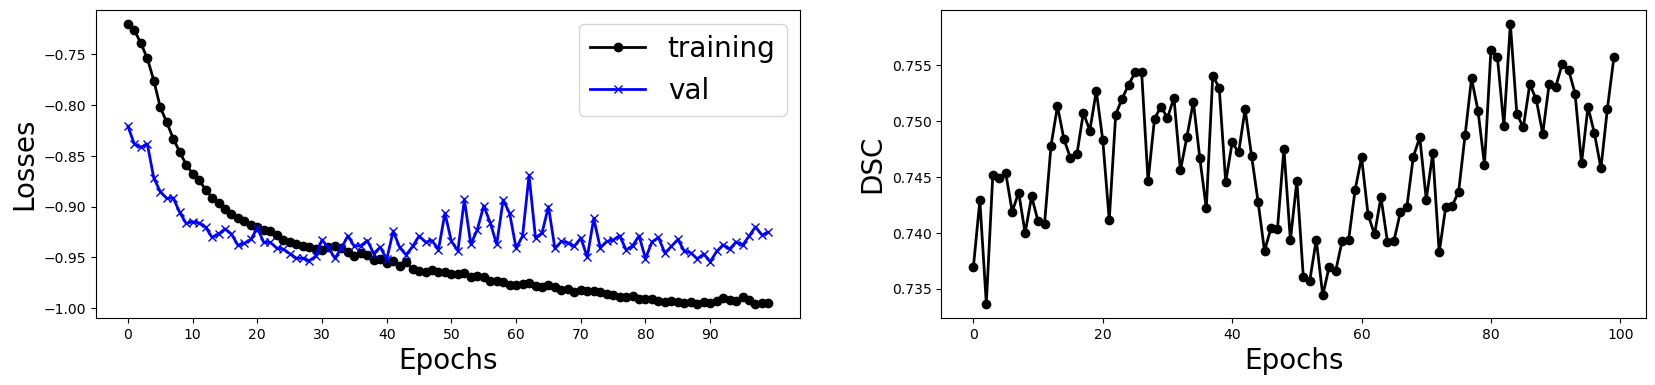

In [18]:
%matplotlib inline
plt.figure("train", (20, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_values, label = 'training', color='k', lw=2, linestyle='-', marker = 'o')
plt.plot(epoch_val_loss_values, label = 'val', color='b', lw=2, linestyle='-', marker = 'x')
plt.legend(fontsize=20, loc='upper right', ncol=1)
plt.xticks(range(0, max_epochs , 10))
plt.ylabel('Losses', fontsize=20)
plt.xlabel('Epochs', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(metric_values, label = 'training', color='k', lw=2, linestyle='-', marker = 'o')
plt.ylabel('DSC', fontsize=20)
plt.xlabel('Epochs', fontsize=20)

In [19]:
def hausdorff (mask1, mask2):
    mask1_class_LV = mask1.copy()
    mask1_class_Myo = mask1.copy()
    
    mask1_class_LV[mask1_class_LV==1] = 0
    mask1_class_Myo[mask1_class_Myo==2] = 0
    
    mask2_class_LV = mask2.copy()
    mask2_class_Myo = mask2.copy()
    
    mask2_class_LV[mask2_class_LV==1] = 0
    mask2_class_Myo[mask2_class_Myo==2] = 0
    
    hausdorff_Myo = (directed_hausdorff(mask1_class_Myo, mask2_class_Myo)[0]+directed_hausdorff(mask2_class_Myo, mask1_class_Myo)[0])/2

    hausdorff_LV = (directed_hausdorff(mask1_class_LV, mask2_class_LV)[0]+directed_hausdorff(mask2_class_LV, mask1_class_LV)[0])/2
    
    return [hausdorff_Myo, hausdorff_LV]

In [20]:
model.load_state_dict(torch.load(os.path.join(root_dir, fileNames+'.pth')))
model.eval()

metric = monai.metrics.MSEMetric()

before_MSEMetric = []
after_MSEMetric = []

before_compute_meandice = []
after_compute_meandice = []

before_compute_hausdorff_distance = []
after_compute_hausdorff_distance = []
                                                                         

for fixed_val_img_, fixed_val_msk_, moving_val_img_, moving_val_msk_ in zip(fixed_val_img, fixed_val_msk,
                                                                                        moving_val_img, moving_val_msk): 
    
    fixed_val_img_ = fixed_val_img_.to(device)
    fixed_val_msk_ = fixed_val_msk_.to(device)

    moving_val_img_ = moving_val_img_.to(device)
    moving_val_msk_ = moving_val_msk_.to(device)


    ddf_val = model(torch.cat((moving_val_img_, fixed_val_img_), dim=1))

    pred_image_val = warp_layer(moving_val_img_, ddf_val)
    pred_mask_val = warp_layer(moving_val_msk_, ddf_val)
    
    
    before_MSEMetric.extend(metric(moving_val_img_,fixed_val_img_).detach().cpu().numpy())
    
    after_MSEMetric.extend(metric(pred_image_val,fixed_val_img_).detach().cpu().numpy())
    
#     print(metric(pred_image_val,fixed_val_img_).detach().cpu().numpy())

    before_compute_hausdorff_distance.extend((compute_hausdorff_distance(y_pred = make_one_hot(moving_val_msk_, C=3), y=make_one_hot(fixed_val_msk_, C=3), directed=True)).detach().cpu().numpy())
    after_compute_hausdorff_distance.extend((compute_hausdorff_distance(y_pred = make_one_hot(pred_mask_val, C=3), y=make_one_hot(fixed_val_msk_, C=3), directed=True)).detach().cpu().numpy()) 
    
    
    before_compute_meandice.extend((compute_meandice(y_pred = make_one_hot(moving_val_msk_, C=3), y=make_one_hot(fixed_val_msk_, C=3))).detach().cpu().numpy())
    after_compute_meandice.extend((compute_meandice(y_pred = make_one_hot(pred_mask_val, C=3), y=make_one_hot(fixed_val_msk_, C=3))).detach().cpu().numpy()) 
    
    
#     break

print(np.array(before_MSEMetric).shape)
print(np.array(after_MSEMetric).shape)

print(np.array(before_compute_meandice).shape)
print(np.array(after_compute_meandice).shape)

print()

print(f'MSEMetric W/O registration {np.mean(np.array(before_MSEMetric))}')
print(f'MSEMetric W/ registration = {np.mean(np.array(after_MSEMetric))}')

print(f'Mean dice W/O registration = {np.mean(np.array(before_compute_meandice), axis=0)}')
print(f'Mean dice W/ registration = {np.mean(np.array(after_compute_meandice), axis=0)}')

print(f'Hausdorff_distance W/O registration = {np.mean(np.array(before_compute_hausdorff_distance), axis=0)}')
print(f'Hausdorff_distance W/ registration = {np.mean(np.array(after_compute_hausdorff_distance), axis=0)}')

print()

print('----------------For Report Metric +/- Std-----------------------')
print(f'Mean dice W/O registration = {np.mean(np.mean(np.array(before_compute_meandice), axis=0))} + {np.mean(np.std(np.array(before_compute_meandice), axis=0))}')
print(f'Mean dice W/ registration = {np.mean(np.mean(np.array(after_compute_meandice), axis=0))} + {np.mean(np.std(np.array(after_compute_meandice), axis=0))}')

print(f'Hausdorff_distance W/O registration = {np.mean(np.mean(np.array(before_compute_hausdorff_distance), axis=0))} + {np.mean(np.std(np.array(before_compute_hausdorff_distance), axis=0))}')
print(f'Hausdorff_distance W/ registration = {np.mean(np.mean(np.array(after_compute_hausdorff_distance), axis=0))} + {np.mean(np.std(np.array(after_compute_hausdorff_distance), axis=0))}')

df = ({
     'before_compute_hausdorff_distance':np.mean(np.array(before_compute_hausdorff_distance), axis=1),
     'after_compute_hausdorff_distance'   : np.mean(np.array(after_compute_hausdorff_distance), axis=1),
     'before_compute_meandice':np.mean(np.array(before_compute_meandice), axis=1),
     'after_compute_meandice':np.mean(np.array(after_compute_meandice), axis=1),
     'before_MSEMetric': np.mean(np.array(before_MSEMetric), axis=1),
     'after_MSEMetric':np.mean(np.array(after_MSEMetric), axis=1)
})

pd.DataFrame(df).to_csv(fileNames+'.csv')

<function compute_meandice at 0x7f7e4c0b01f0>: Function `compute_meandice` has been deprecated since version 1.0.0. use `compute_dice` instead.


(4, 1)
(4, 1)
(4, 3)
(4, 3)

MSEMetric W/O registration 0.0037749039474874735
MSEMetric W/ registration = 0.002305464120581746
Mean dice W/O registration = [0.9909303  0.7891744  0.72605586]
Mean dice W/ registration = [0.9870649  0.6956232  0.59339863]
Hausdorff_distance W/O registration = [5.8599326 6.2704711]
Hausdorff_distance W/ registration = [22.59777202  6.89339021]

----------------For Report Metric +/- Std-----------------------
Mean dice W/O registration = 0.8353868126869202 + 0.1279802769422531
Mean dice W/ registration = 0.7586956024169922 + 0.07070813328027725
Hausdorff_distance W/O registration = 6.065201854061436 + 2.158310792469111
Hausdorff_distance W/ registration = 14.745581114875023 + 3.320233815487197


In [21]:
model.load_state_dict(torch.load(os.path.join(root_dir, fileNames+'.pth')))
model.eval()
                                          

for fixed_val_img_, fixed_val_msk_, moving_val_img_, moving_val_msk_ in zip(fixed_val_img, fixed_val_msk,
                                                                                        moving_val_img, moving_val_msk): 
    
    fixed_val_img_ = fixed_val_img_.to(device)
    fixed_val_msk_ = fixed_val_msk_.to(device)

    moving_val_img_ = moving_val_img_.to(device)
    moving_val_msk_ = moving_val_msk_.to(device)


    ddf_val = model(torch.cat((moving_val_img_, fixed_val_img_), dim=1))

    pred_image_val = warp_layer(moving_val_img_, ddf_val)
    pred_mask_val = warp_layer(moving_val_msk_, ddf_val)
    
    
    break

fixed_val_img_ = fixed_val_img_.detach().cpu().numpy()[:, 0]
fixed_val_msk_ = fixed_val_msk_.detach().cpu().numpy()[:, 0]

moving_val_img_ = moving_val_img_.detach().cpu().numpy()[:, 0]
moving_val_msk_ = moving_val_msk_.detach().cpu().numpy()[:, 0]

pred_image_val = pred_image_val.detach().cpu().numpy()[:, 0]
pred_mask_val = pred_mask_val.detach().cpu().numpy()[:, 0]

In [22]:
def colored (pred_img, true_img): 
    bitwise_and = cv2.bitwise_and(pred_img, true_img)
    
    TP = np.stack((np.zeros_like(bitwise_and), bitwise_and, np.zeros_like(bitwise_and)), axis=-1)
    
    FN = np.stack((true_img-bitwise_and,
                   true_img-bitwise_and,
                   np.zeros_like(true_img-bitwise_and)), axis=-1)
    
    FP = np.stack((pred_img-bitwise_and,
                   pred_img-bitwise_and,
                  np.zeros_like(pred_img-bitwise_and)), axis=-1)
    
    return (255*(TP+FN+FP)).astype('uint8')

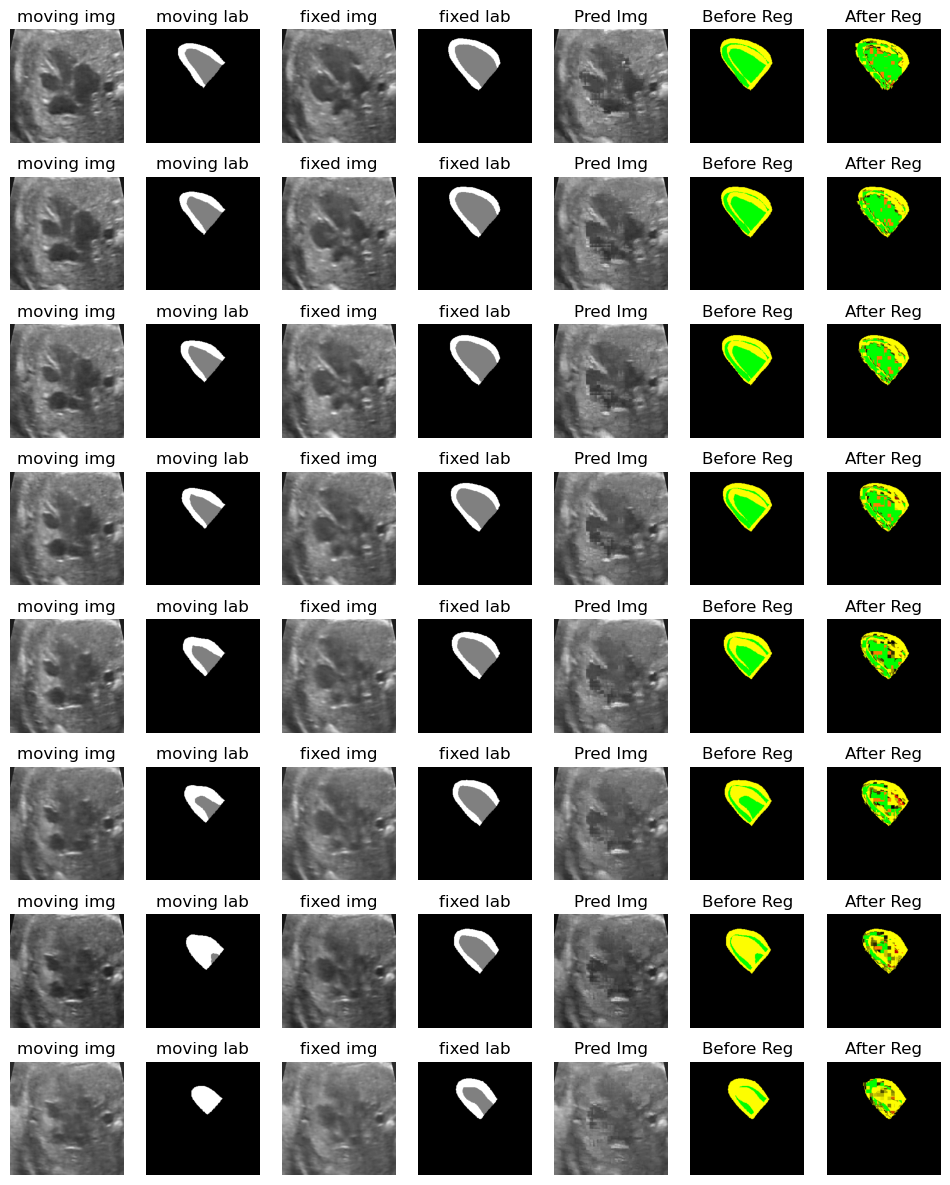

In [23]:
slice_no = 15
%matplotlib inline
slice_num = 8
plt.subplots(slice_num, 7, figsize=(12, 15))

for b in range(slice_num):
    # moving image
    plt.subplot(slice_num, 7, b * 7 + 1)
    plt.axis('off')
    plt.title("moving img")
    plt.imshow(moving_val_img_[0, :, :, slice_no], cmap="gray")
    
    # moving label
    plt.subplot(slice_num, 7, b * 7 + 2)
    plt.axis('off')
    plt.title("moving lab")
    plt.imshow(moving_val_msk_[0, :, :, slice_no], cmap="gray")
    
    
    # fixed image
    plt.subplot(slice_num, 7, b * 7 + 3)
    plt.axis('off')
    plt.title("fixed img")
    plt.imshow(fixed_val_img_[0, :, :, slice_no], cmap="gray")
    
    # fixed label
    plt.subplot(slice_num, 7, b * 7 + 4)
    plt.axis('off')
    plt.title("fixed lab")
    plt.imshow(fixed_val_msk_[0, :, :, slice_no], cmap="gray")
    
    
    # warped moving
    plt.subplot(slice_num, 7, b * 7 + 5)
    plt.axis('off')
    plt.title("Pred Img")
    plt.imshow(pred_image_val[0, :, :, slice_no], cmap="gray")


    # warped moving
    plt.subplot(slice_num, 7, b * 7 + 6)
    plt.axis('off')
    plt.title("Before Reg")
    plt.imshow(colored(moving_val_msk_[0, :, :, slice_no], fixed_val_msk_[0, :, :, slice_no]))
    
    
    # warped moving
    plt.subplot(slice_num, 7, b * 7 + 7)
    plt.axis('off')
    plt.title("After Reg")
    plt.imshow(colored(pred_mask_val[0, :, :, slice_no], fixed_val_msk_[0, :, :, slice_no]))

    slice_no = slice_no + 1
    
plt.axis('off')
plt.show()